# Multi-Label Classification

In [1]:
from fastai.vision.all import *

In [2]:
#Download data
path = untar_data(URLs.PASCAL_2007)
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [5]:
#Constructing a DataBlock
dblock = DataBlock()
dsets = dblock.datasets(df)
dsets.train[0]

(fname       000395.jpg
 labels            bird
 is_valid         False
 Name: 194, dtype: object,
 fname       000395.jpg
 labels            bird
 is_valid         False
 Name: 194, dtype: object)

In [6]:
#Correct input and output for DataBlock
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('003821.jpg', 'dog')

In [14]:
#Gets the paths and the labels
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('C:/Users/joaqu/.fastai/data/pascal_2007/train/000129.jpg'),
 ['bicycle', 'person'])

In [16]:
#Get PILImage and prepare labels for multicategory
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock), get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x414,
 TensorMultiCategory([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
                      0., 0., 0., 0., 0.]))

In [17]:
# Check the label of an image
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#2) ['boat','person']

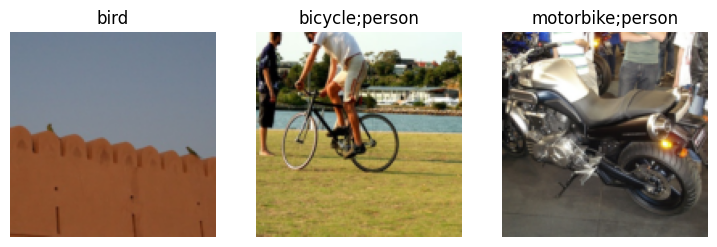

In [22]:
#Split data in train and validation
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, get_y=get_y, 
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

dls.show_batch(nrows=1, ncols=3)

In [24]:
# Use BCEWithLogitsLoss for one-hot-encoded target
loss_func = nn.BCEWithLogitsLoss()

#Accuaracy for multiple targets
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: 
        inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

c:\Users\joaqu\anaconda3\envs\pytorch_env\Lib\site-packages\fastai\vision\learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\joaqu/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 77.0MB/s]


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.953661,0.711058,0.611872,01:05
1,0.825133,0.528095,0.763426,00:30
2,0.602044,0.193143,0.954781,00:27
3,0.356183,0.118037,0.961713,00:26


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.127521,0.102430,0.965239,00:30
1,0.112672,0.097207,0.966474,00:31
2,0.096840,0.094751,0.967231,00:32


In [25]:
#Picking a threshold is important
#If you pick a threshold that’s too low, you’ll often be failing to select correctly labeled objects

learn.metrics = partial(accuracy_multi, thresh=0.1)
print('threshold = 0.1:  ',learn.validate())

learn.metrics = partial(accuracy_multi, thresh=0.99)
print('threshold = 0.99:  ',learn.validate())

threshold = 0.1:   [0.09475072473287582, 0.9377889633178711]


threshold = 0.99:   [0.09475072473287582, 0.9416933059692383]


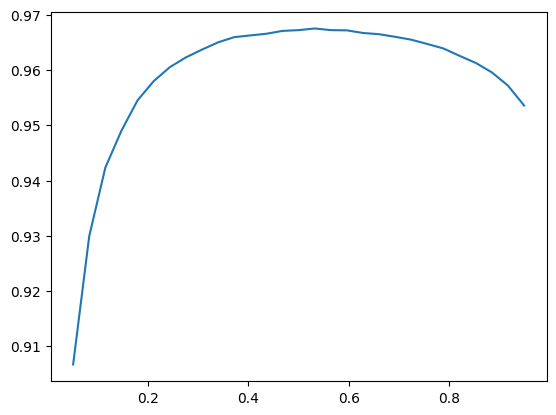

In [27]:
#Accuaracy depending on the threshold.
preds,targs = learn.get_preds()
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);